This notebook shows

* integration with Ignite
* debugging capabilities ([Keras input shape][2])
* control flow


Slight modification from [Ignite's MNIST example][1].

[1]:https://github.com/pytorch/ignite/blob/master/examples/mnist/mnist.py
[2]:https://keras.io/getting-started/sequential-model-guide/

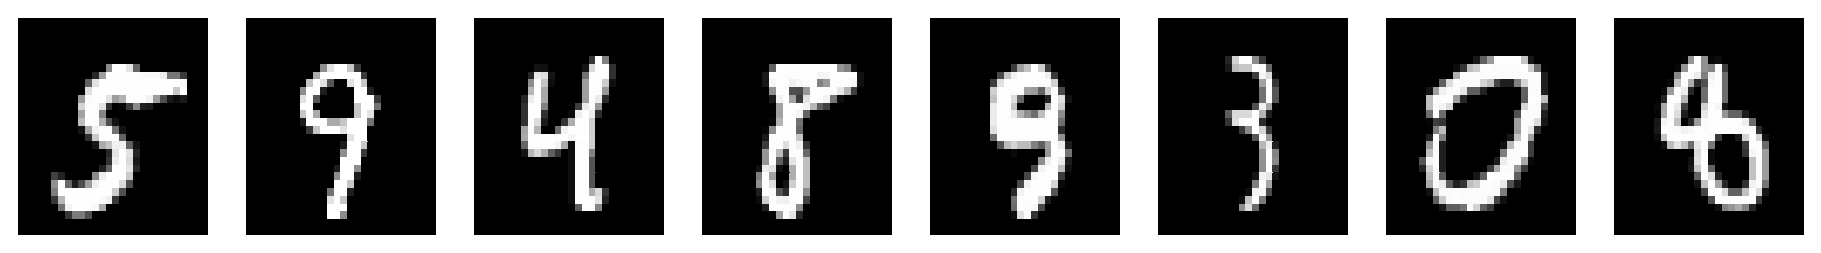

In [2]:
from toolz import first
import seaborn as sns
import matplotlib.pyplot as plt
sample, _ = get_data_loaders(64, 1000)
imgs = first(sample)[0]

fig, axs = plt.subplots(ncols=8, figsize=(8 * 2, 2))
for i, ax in enumerate(axs):
    _ = sns.heatmap(imgs[i].reshape(28, 28), cmap="gray",
                    ax=ax, cbar=False, xticklabels=False, yticklabels=False)

## Estimator creation

In [9]:
from torch import nn
import torch.nn.functional as F
import random

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        import ipdb as pdb; pdb.set_trace()
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        
        if random.choice([0, 1]) == 1:
            x = F.dropout(x, training=self.training)
        
        x = self.fc2(x)
            
        return F.log_softmax(x, dim=-1)

## Training data

In [3]:
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import MNIST

def get_data_loaders(train_batch_size, val_batch_size):
    data_transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    train_loader = DataLoader(MNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(MNIST(download=False, root=".", transform=data_transform, train=False),
                            batch_size=val_batch_size, shuffle=False)
    return train_loader, test_loader

## Train and view progress

In [4]:
from types import SimpleNamespace
args = {
    "batch_size": 64,  "val_batch_size": 1000,
    "epochs": 10, "lr": 0.01,
    "momentum": 0.5, "log_interval": int(938 / 20)
}
args = SimpleNamespace(**args)

In [10]:
from torch.optim import SGD
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from time import time

train_loader, val_loader = get_data_loaders(args.batch_size, args.val_batch_size)
model = Net()

optimizer = SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
trainer = create_supervised_trainer(model, optimizer, F.nll_loss, device="cpu")
start = time()

@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter_ = (engine.state.iteration - 1) % len(train_loader) + 1
    loss = engine.state.output
    if iter_ % args.log_interval == 0:
        print(f"Iteration {iter_}: time={time() - start:0.2f}, loss={loss:.2f}")

trainer.run(train_loader, max_epochs=args.epochs)

> <ipython-input-9-2eb839fa235f>(16)forward()
     15         import ipdb as pdb; pdb.set_trace()
---> 16         x = F.relu(F.max_pool2d(self.conv1(x), 2))
     17         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))



ipdb>  x.size()


torch.Size([64, 1, 28, 28])


ipdb>  n


> <ipython-input-9-2eb839fa235f>(17)forward()
     16         x = F.relu(F.max_pool2d(self.conv1(x), 2))
---> 17         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
     18         x = x.view(-1, 320)



ipdb>  p x.size()


torch.Size([64, 10, 12, 12])


ipdb>  n


> <ipython-input-9-2eb839fa235f>(18)forward()
     17         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
---> 18         x = x.view(-1, 320)
     19         x = F.relu(self.fc1(x))



ipdb>  p x.size()


torch.Size([64, 20, 4, 4])


ipdb>  n


> <ipython-input-9-2eb839fa235f>(19)forward()
     18         x = x.view(-1, 320)
---> 19         x = F.relu(self.fc1(x))
     20 



ipdb>  p x.size()


torch.Size([64, 320])


ipdb>  q


BdbQuit: 

In [11]:
import tensorflow as tf
tf.cond?
# tf.while_loop

/Users/scott/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Signature: tf.cond(pred, true_fn=None, false_fn=None, strict=False, name=None, fn1=None, fn2=None)
Docstring:
Return `true_fn()` if the predicate `pred` is true else `false_fn()`. (deprecated arguments)

SOME ARGUMENTS ARE DEPRECATED. They will be removed in a future version.
Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.

`true_fn` and `false_fn` both return lists of output tensors. `true_fn` and
`false_fn` must have the same non-zero number and type of outputs.

**WARNING**: Any Tensors or Operations created outside of `true_fn` and
`false_fn` will be executed regardless of which branch is selected at runtime.

Although this behavior is consistent with the dataflow model of TensorFlow,
it has frequently surprised users who expected a lazier semantics.
Consider the following simple program:

```python
z = tf.multiply(a, b)
result = tf.cond(x < y, lambda: tf.add(x, z), lambda: tf.square(y))
```

If `x < y`, the `tf.add` operation will be e